In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [2]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [3]:
# 데이터 가져오기
california = fetch_california_housing()
data, labels = california.data, california.target

In [4]:
data.shape

(20640, 8)

In [5]:
# 데이터 정규화
scaler = StandardScaler()
data = scaler.fit_transform(data)

In [6]:
# 데이터 분할
X_train, X_temp, y_train, y_temp = train_test_split(data, labels, test_size=0.4, random_state=11)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=11)

In [7]:
# transform 클래스 정의
class ToTensor:
    def __call__(self, data, labels):
        data = torch.tensor(data, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.float32)
        return data, labels

In [8]:
## CustomDataset 클래스 정의
class HousingDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        data, labels = self.data[idx], self.labels[idx]

        if self.transform :
            data, labels = self.transform(data, labels)
        return data, labels

In [9]:
# 데이터셋 및 데이터 로더 생성
transform = ToTensor()

# 데이터셋 만들기
train_dataset = HousingDataset(X_train, y_train, transform=transform)
val_dataset = HousingDataset(X_val, y_val, transform=transform)
test_dataset = HousingDataset(X_test, y_test, transform=transform)

# 데이터 로더 만들기
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [10]:
# 간단한 Pytorch모델 정의

class MyCustomModel(nn.Module):
    def __init__(self):
        super(MyCustomModel, self).__init__()
        self.fc1 = nn.Linear(8, 64)
        self.dropout1 = nn.Dropout(p=0.4)
        self.fc2 = nn.Linear(64, 64)
        self.dropout2 = nn.Dropout(p=0.5)
        self.fc3 = nn.Linear(64, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        # 첫번째 레이어
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout1(x)

        # 두번째 레이어
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout2(x)

        # 출력층
        x = self.fc3(x)
        
        return x

In [11]:
# GPU 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [12]:
# 모델, 손실함수, 옵티마이저 설정
model = MyCustomModel().to(device)
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.01, weight_decay=0.01)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# 학습 및 검증 루프
epochs = 50
train_losses = []
val_losses = []

for epoch in range(epochs):
    model.train()
    train_loss = 0.0

    for data, labels in train_loader:
        data, labels = data.to(device), labels.to(device).unsqueeze(1)

        ouputs = model(data) # 예측 결과
        loss = criterion(ouputs, labels) # 예측값과 실제값의 loss 계산

        optimizer.zero_grad() # 가중치 초기화
        loss.backward() # 역전파 알아서 해주기
        optimizer.step() # 가중치 업데이트

        train_loss += loss.item()
    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # 검증 loss 계산하기
    model.eval()
    val_loss = 0.0
    with torch.no_grad(): # 가중치 업데이트를 하지 않겠다
        for data, labels in val_loader:
            data, labels = data.to(device), labels.to(device).unsqueeze(1)

            ouputs = model(data)
            loss = criterion(ouputs, labels) # 평가 loss
            val_loss += loss.item()
        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        scheduler.step()
        print(f"{epoch} 마다 train_loss : {train_loss:.4f}, val_loss : {val_loss:.4f}")

0 마다 train_loss : 0.7371, val_loss : 0.5425
1 마다 train_loss : 0.5494, val_loss : 0.5203
2 마다 train_loss : 0.5586, val_loss : 0.4314
3 마다 train_loss : 0.5328, val_loss : 0.4668
4 마다 train_loss : 0.5381, val_loss : 0.4168
5 마다 train_loss : 0.5461, val_loss : 0.4295
6 마다 train_loss : 0.5479, val_loss : 0.4080
7 마다 train_loss : 0.5580, val_loss : 0.4116
8 마다 train_loss : 0.5233, val_loss : 0.4475
9 마다 train_loss : 0.5527, val_loss : 0.4539
10 마다 train_loss : 0.5044, val_loss : 0.4083
11 마다 train_loss : 0.5055, val_loss : 0.3873
12 마다 train_loss : 0.4593, val_loss : 0.4115
13 마다 train_loss : 0.4468, val_loss : 0.4135
14 마다 train_loss : 0.4413, val_loss : 0.4113
15 마다 train_loss : 0.4411, val_loss : 0.4247
16 마다 train_loss : 0.4646, val_loss : 0.3638
17 마다 train_loss : 0.4447, val_loss : 0.3660
18 마다 train_loss : 0.4233, val_loss : 0.3638
19 마다 train_loss : 0.4163, val_loss : 0.3550
20 마다 train_loss : 0.4133, val_loss : 0.3543
21 마다 train_loss : 0.4187, val_loss : 0.3523
22 마다 train_loss : 0

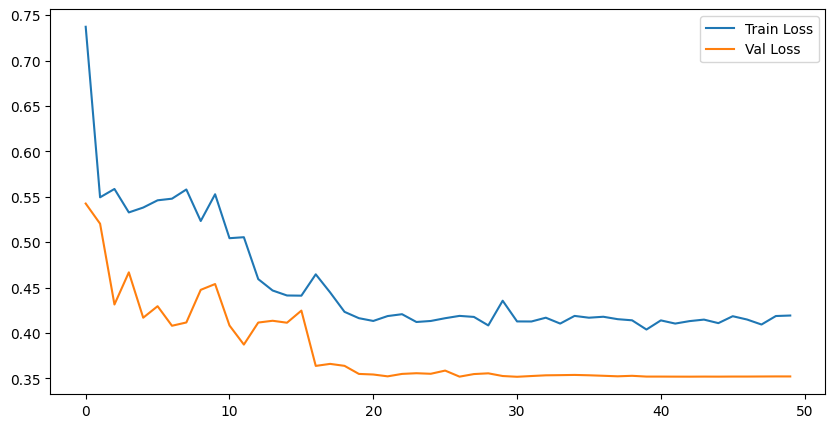

In [13]:
# 시각화 해보기
plt.figure(figsize=(10,5))
plt.plot(range(epochs), train_losses, label='Train Loss')
plt.plot(range(epochs), val_losses, label='Val Loss')
plt.legend()
plt.show()

In [14]:
# 모델 평가
model.eval()

test_loss = 0.0
with torch.no_grad():
    for data, labels in test_loader:
        data, labels = data.to(device), labels.to(device).unsqueeze(1)
        outputs = model(data)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
test_loss /= len(test_loader)
print(f"Test Loss: {test_loss:.4f}")

Test Loss: 0.3537


In [15]:
import numpy as np
# 최종예측
sample = torch.tensor(np.array([X_test[0]]), dtype=torch.float32).to(device) # 예측해볼 데이터 하나
model.eval()
with torch.no_grad():
    outputs = model(sample)
    print("예측값은", outputs.item(), "실제값은", y_test[0])

예측값은 3.6930553913116455 실제값은 3.506
